# Notebook to Evaluate Models

## Setup

In [1]:
# imports
import matplotlib.pyplot as plt
from monai.networks.nets import SwinUNETR
import nibabel as nib
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from tqdm import tqdm
import umap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# set random seeds for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)


Using device: cuda


In [3]:
# pretrained checkpoints and data root
ckpt_img_clip = "/ministorage/adina/pretrain_sweep/checkpoints/dea46vee/all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt"
ckpt_img_only = "/ministorage/adina/pretrain_sweep_no_clip/checkpoints/ijj3zh4v/all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt"
ckpt_img_clip_rewrites = "/ministorage/adina/pretrain_sweep_rewrites/checkpoints/7w1g9wdt/all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt"
data_root = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"


In [4]:
# define model specs
model_specs = {
    'Image+CLIP': {'path': ckpt_img_clip, 'feature_size': 12, 'embed_dim': 512},
    'Image-only': {'path': ckpt_img_only, 'feature_size': 48, 'embed_dim': 256},
    'Image+CLIP-rewrites': {'path': ckpt_img_clip_rewrites, 'feature_size': 12, 'embed_dim': 128},
    'Random': {'path': None, 'feature_size': 12, 'embed_dim': 512}
}


In [5]:
# define color palette for each model (train, val)
model_colors = {
    'Image+CLIP': ('#1f77b4', '#aec7e8'), # blues
    'Image-only': ('#ff7f0e', '#ffbb78'), # oranges
    'Image+CLIP-rewrites': ('#2ca02c', '#98df8a'), # greens
    'Random': ('#d62728', '#ff9896') # reds
}


## Helper Functions

In [6]:
# function to load fraction of patches from each class
def load_fraction_patches(base_dir, fraction=0.5):

    # ensure fraction is between 0 and 1
    assert 0 < fraction <= 1, "Fraction must be between 0 and 1"

    # initialize lists to hold data and labels
    samples, labels = [], []

    # get class directories
    class_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

    # iterate over each class directory
    for class_dir in class_dirs:

        # get images in class directory
        folder = os.path.join(base_dir, class_dir)
        images = [f for f in os.listdir(folder) if (f.endswith('.nii.gz') or f.endswith('.nii')) and '_label' not in f and 'preds' not in f]

        # ensure images are found
        if not images:
            print(f"No images found in {folder}. Skipping this class.")
            continue
    
        # shuffle and keep fraction of images
        random.shuffle(images)
        num_to_keep = max(2, int(len(images) * fraction))  # ensure at least two images are kept
        images = images[:num_to_keep]

        # load images and corresponding labels
        for i in images:
            path = os.path.join(folder, i)
            img = nib.load(path).get_fdata()
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # normalize to [0, 1]
            samples.append(img[None, None]) # [1, D, H, W]
            labels.append(class_dir)

        # print progress
        print(f'{class_dir}: kept {num_to_keep}/{len(images)} images ({fraction*100:.1f}%)')

    # print total samples loaded
    total = len(samples)
    print(f'\nLoaded {total} total patches across {len(class_dirs)} classes ({fraction*100:.1f}% per class).')

    # return array of samples and labels and classes
    return np.array(samples), np.array(labels), class_dirs


In [7]:
# function to load backbone model
def load_backbone_custom(cfg):

    # get model path and specs
    model_path, model_feats = cfg['path'], cfg['feature_size']
    if model_path is None:
        print(f'Initializing random SwinUNETR (feature size={model_feats})')
        model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=2, feature_size=model_feats).to(device)
        return model.swinViT.eval()
    
    # load checkpoint
    ckpt = torch.load(model_path, map_location='cpu', weights_only=False)
    state_dict = ckpt.get('state_dict', ckpt)
    prefix = next((p for p in ['student_encoder', 'encoder', 'teacher_encoder', 'model', 'module'] if any(k.startswith(p) for k in state_dict)), None)
    if prefix:
        state_dict = {k[len(prefix)+1:]: v for k, v in state_dict.items() if k.startswith(prefix)}
    encoder_state_dict = {k: v for k, v in state_dict.items() if k.startswith('swinViT.')}
    model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=2, feature_size=model_feats).to(device)
    missing = model.load_state_dict(encoder_state_dict, strict=False)
    print(f'Loaded {len(model.state_dict()) - len(missing.missing_keys)}/{len(model.state_dict())} keys from {os.path.basename(model_path)} (feature size={model_feats})')

    # return model
    return model.swinViT.eval()


In [8]:
# function to get embeddings from model
@torch.no_grad()
def get_embeddings(encoder, samples_np):

    # get list of embeddings
    embeddings = []

    # iterate over samples in batches
    for vol in tqdm(samples_np, leave=False):
        x = torch.tensor(vol, dtype=torch.float32).to(device)  # [1, 1, D, H, W]
        out = encoder(x)  # [1, C, D', H', W']
        feat = out[-1] if isinstance(out, list) else out  # get last feature map
        feat = feat.mean(dim=(2, 3, 4))  # global average pooling over D, H, W -> [1, C]
        embeddings.append(feat.squeeze(0).cpu().numpy())  # [C]

    # return array of embeddings
    return np.stack(embeddings)  # [N, C]


In [9]:
# function to create balanced train/val splits
def balanced_train_val_split(X, y, val_ratio=0.2, seed=100):

    # create rng
    rng = np.random.default_rng(seed)

    # get classes
    classes = np.unique(y)

    # create lists for train and val indices
    train_indices, val_indices = [], []

    # iterate over each class
    for cls in classes:

        # get indices for this class and shuffle
        idx = np.where(y == cls)[0]
        rng.shuffle(idx)
        n = len(idx)

        # split indices into train and val
        # special case if only 2 samples
        if n == 2:
            train_indices.append(idx[0])
            val_indices.append(idx[1])

        # general case
        else:
            n_val = max(1, int(round(n * val_ratio)))
            val_indices.extend(idx[:n_val])
            train_indices.extend(idx[n_val:])
            if len(np.where(y[train_indices] == cls)[0]) == 0:
                train_indices.append(val_indices.pop())

    # return arrays of train and val_indices
    return np.array(train_indices), np.array(val_indices)


In [10]:
# function to plot confusion matrices side by side
def plot_conf_matrices_side_by_side(results_dict, labels_list, class_names, model_colors=None):

    # set up figure
    num_models = len(results_dict)
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

    # if only 1 model, make axes a list
    if num_models == 1:
        axes = [axes]

    # iterate over each model and plot confusion matrix
    for ax, (model_name, (true_labels, preds)) in zip(axes, results_dict.items()):
        cm = confusion_matrix(true_labels, preds, labels=list(range(len(class_names))))
        cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        # get model-specific color map if provided
        if model_colors and model_name in model_colors:
            base_color = model_colors[model_name][0]
            cmap = sns.light_palette(base_color, as_cmap=True)
        else:
            cmap = 'Blues'

        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=cmap, xticklabels=class_names, yticklabels=class_names, ax=ax, cbar=False)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    # format and show plot
    plt.tight_layout()
    plt.show()


In [11]:
# function to plot umap
def plot_umap(embeddings_dict, labels):

    # set up umap reducer
    reducer = umap.UMAP(random_state=100)

    # set up figure
    fig, axs = plt.subplots(1, len(embeddings_dict), figsize=(5 * len(embeddings_dict), 5))

    # if only 1 model, make axs a list
    if len(embeddings_dict) == 1:
        axs = [axs]

    # iterate over each model and plot umap
    for ax, (model_name, embeddings) in zip(axs, embeddings_dict.items()):
        XY = reducer.fit_transform(embeddings)
        for class_lab in np.unique(labels):
            idx = labels == class_lab
            ax.scatter(XY[idx, 0], XY[idx, 1], s=10, alpha=0.7, label=class_lab)
        ax.set_title(f'UMAP: {model_name}')
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
    axs[0].legend(markerscale=1.2, fontsize=8)
    
    # format  and show plot
    plt.tight_layout()
    plt.show()


## Pytorch Linear Probe

In [12]:
# function to perform linear probing with PyTorch
def linear_probe_torch(embeddings, labels, num_epochs=10, lr=1e-3, batch_size=16, model_name='Model'):

    # map labels to integers
    unique_labels = sorted(set(labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    y = np.array([label_to_idx[label] for label in labels])

    # create balanced train/val split
    train_idx, val_idx = balanced_train_val_split(np.arange(len(embeddings)), y)
    X_train, X_val = embeddings[train_idx], embeddings[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # log how many samples in each split
    print(f'\n[{model_name}] Train/Val class distribution:')
    y_train_np = y_train.cpu().numpy() if torch.is_tensor(y_train) else y_train
    y_val_np = y_val.cpu().numpy() if torch.is_tensor(y_val) else y_val
    for cls_name, cls_idx in label_to_idx.items():
        n_train = np.sum(y_train_np == cls_idx)
        n_val = np.sum(y_val_np == cls_idx)
        print(f'  {cls_name:20s} | Train: {n_train:3d} | Val: {n_val:3d} | Total: {n_train + n_val:3d}')
    print('-' * 60)

    # convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # create dataloaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

    # configure model
    in_dim = embeddings.shape[1]
    num_classes = len(unique_labels)
    model = nn.Linear(in_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # define lists for train/val losses and accuracies
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    # training loop
    for epoch in range(num_epochs):

        # training phase
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            train_loss = criterion(logits, yb)
            train_loss.backward()
            optimizer.step()
            total_train_loss += train_loss.item() * Xb.size(0)
            correct_train += (logits.argmax(dim=1) == yb).sum().item()
            total_train += yb.size(0)
        train_losses.append(total_train_loss / len(train_loader.dataset))
        train_accuracies.append(correct_train / total_train)

        # validation phase
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        preds, true_labels = [], []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.to(device)
                logits = model(Xb)
                val_loss = criterion(logits, yb.to(device))
                total_val_loss += val_loss.item() * Xb.size(0)
                pred = torch.argmax(logits, dim=1).cpu()
                preds.append(pred)
                true_labels.append(yb)
                correct_val += (pred == yb).sum().item()
                total_val += yb.size(0)
        preds = torch.cat(preds)
        true_labels = torch.cat(true_labels)
        val_losses.append(total_val_loss / len(val_loader.dataset))
        val_accuracies.append(correct_val / total_val)

        # print epoch summary
        print(f'{model_name} | Epoch {epoch+1:02d}/{num_epochs} | Train loss: {train_losses[-1]:.4f} | Val loss: {val_losses[-1]:.4f} | Train acc: {train_accuracies[-1]:.3f} | Val acc: {val_accuracies[-1]:.3f}')

    # compute silhouette score on validation set
    sil = silhouette_score(embeddings, y)

    # return metrics
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'final_val_accuracy': val_accuracies[-1],
        'silhouette_score': sil,
        'true_labels': true_labels.numpy(),
        'predictions': preds.numpy(),
        'class_names': unique_labels
    }


## Pipeline

In [13]:
# function to compute embeddings
def compute_embeddings(model_specs, samples):

    # dict for embeddings
    embeddings_dict = {}

    # iterate over each model spec
    for model_name, cfg in model_specs.items():

        print(f'\n=== {model_name} ===')

        # load backbone model
        encoder = load_backbone_custom(cfg)

        # compute embeddings
        embeddings = get_embeddings(encoder, samples)

        # store embeddings
        embeddings_dict[model_name] = embeddings

    return embeddings_dict

In [14]:
# run linear probing
def run_linear_probing(embeddings, labels, model_specs, num_epochs=10, lr=1e-3, batch_size=8):
    
    # collect curve info, results, and confusion matrix results
    curve_logs, final_results, conf_results = {}, [], {}

    # iterate over embeddings
    for model_name, emb in embeddings.items():

        print(f'\n--- Linear Probing: {model_name} ---')

        # run linear probe
        log = linear_probe_torch(embeddings=emb, labels=labels, num_epochs=num_epochs, lr=lr, batch_size=batch_size, model_name=model_name)
        curve_logs[model_name] = log

        # store confusion matrix results
        conf_results[model_name] = (log['true_labels'], log['predictions'])

        # store final results
        final_results.append({
            'Model': model_name,
            'Feature size': model_specs[model_name]['feature_size'],
            'Embedding dim': model_specs[model_name]['embed_dim'],
            'Final Val Accuracy': log['final_val_accuracy'],
            'Silhouette Score': log['silhouette_score']
        })

    return curve_logs, final_results, conf_results


In [15]:
# function to plot train/val loss and accuracy curves
def plot_training_curves(curve_logs, model_colors):

    # loss plot
    plt.figure(figsize=(7, 5))
    for name, log in curve_logs.items():
        color_train, color_val = model_colors.get(name, ('gray', 'lightgray'))
        plt.plot(log['train_losses'], label=f'{name} train', color=color_train, linestyle='-')
        plt.plot(log['val_losses'], label=f'{name} val', color=color_val, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Val Loss Curves - All Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # accuracy plot
    plt.figure(figsize=(7, 5))
    for name, log in curve_logs.items():
        color_train, color_val = model_colors.get(name, ('gray', 'lightgray'))
        plt.plot(log['train_accuracies'], label=f'{name} train', color=color_train, linestyle='-')
        plt.plot(log['val_accuracies'], label=f'{name} val', color=color_val, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Val Accuracy Curves - All Models')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [16]:
# function to summarize final results and plot umap
def summarize_and_plot_umap(results, embeddings, labels):

    # plot umap
    plot_umap(embeddings, labels)

    # create dataframe of final results
    df_results = pd.DataFrame(results).sort_values(by='Final Val Accuracy', ascending=False)
    print('\n=== Summary of Final Results ===')
    display(df_results)


In [25]:
# main function for full eval pipeline
def main(data_root, model_specs, model_colors, num_epochs=10, fraction=0.5):

    # load data
    print('Loading data...')
    samples, labels, class_names = load_fraction_patches(data_root, fraction=fraction)

    # compute embeddings
    embeddings_dict = compute_embeddings(model_specs, samples)

    # run linear probing
    curve_logs, final_results, conf_results = run_linear_probing(embeddings_dict, labels, model_specs, num_epochs=num_epochs, lr=1e-3, batch_size=8)

    # plot training curves
    plot_training_curves(curve_logs, model_colors)

    # plot confusion matrices
    plot_conf_matrices_side_by_side(conf_results, labels, class_names, model_colors=model_colors)

    # summarize results and plot umap
    summarize_and_plot_umap(final_results, embeddings_dict, labels)

    return embeddings_dict, labels, class_names, final_results
    

## Main Entry Point

Loading data...
amyloid_plaque_patches: kept 9/9 images (50.0%)
c_fos_positive_patches: kept 2/2 images (50.0%)
cell_nucleus_patches: kept 12/12 images (50.0%)
vessels_patches: kept 20/20 images (50.0%)

Loaded 43 total patches across 4 classes (50.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---

[Image+CLIP] Train/Val class distribution:
  amyloid_plaque_patches | Train:   7 | Val:   2 | Total:   9
  c_fos_positive_patches | Train:   1 | Val:   1 | Total:   2
  cell_nucleus_patches | Train:  10 | Val:   2 | Total:  12
  vessels_patches      | Train:  16 | Val:   4 | Total:  20
------------------------------------------------------------
Image+CLIP | Epoch 01/10 | Train loss: 1.5956 | Val loss: 1.3633 | Train acc: 0.029 | Val acc: 0.333
Image+CLIP | Epoch 02/10 | Train loss: 1.3098 | Val loss: 1.1705 | Train acc: 0.324 | Val acc: 0.556
Image+CLIP | Epoch 03/10 | Train loss: 1.0996 | Val loss: 1.0264 | Train acc: 0.706 | Val acc: 0.778
Image+CLIP | Epoch 04/10 | Train loss: 0.9414 | Val loss: 0.9121 | Train acc: 0.794 | Val acc: 0.778
Image+CLIP | Epoch 05/10 | Train loss: 0.8271 | Val loss: 0.8340 | Train acc: 0.794 | Val acc: 0.778
Image+CLIP | Epoch 06/10 | Train loss: 0.7338 | Val loss: 0.7728 | Train acc: 0.765 | Val acc: 0.778
Image+CLI

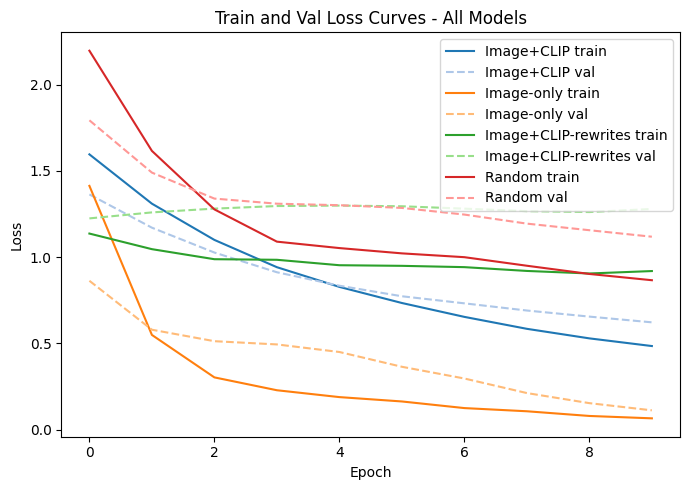

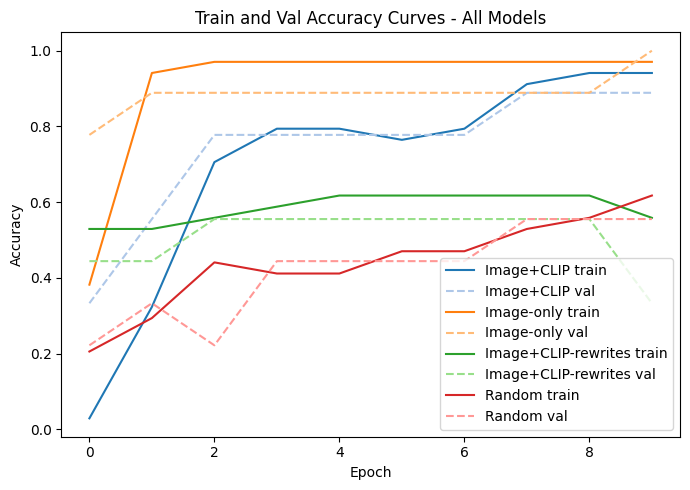

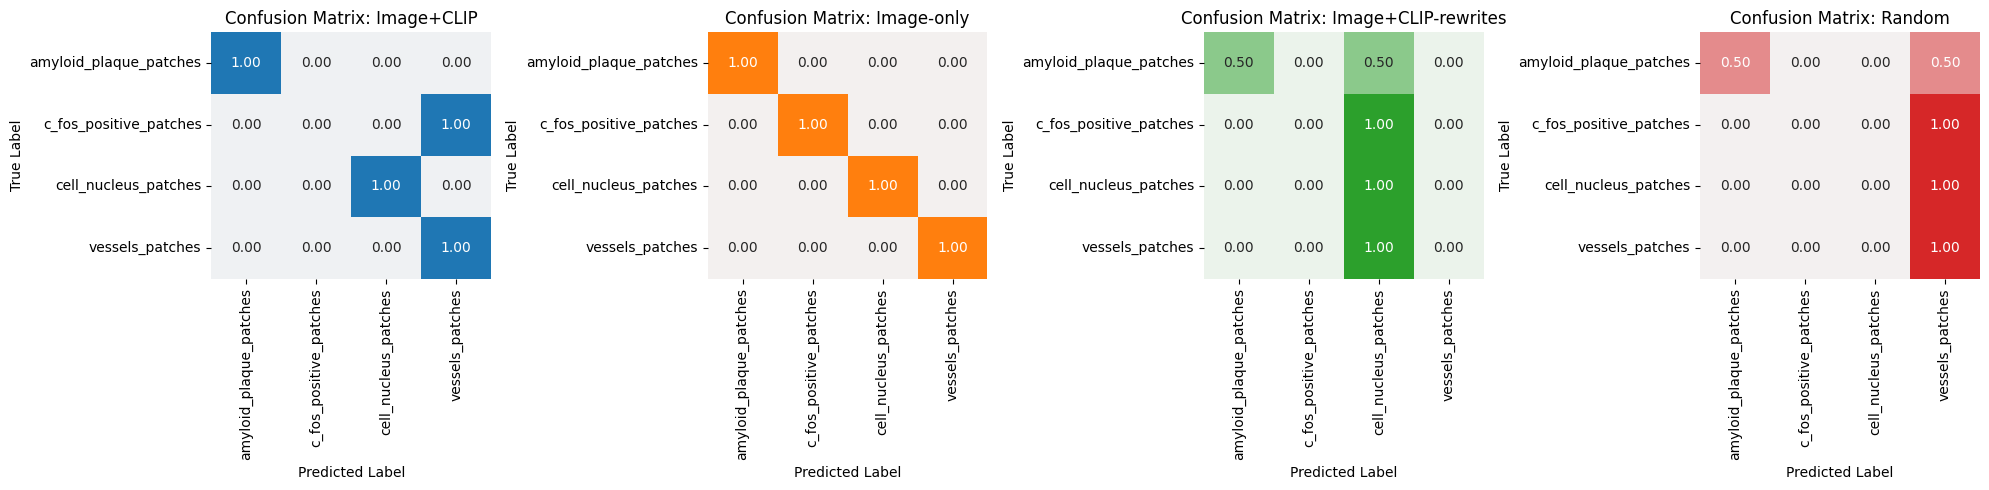

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


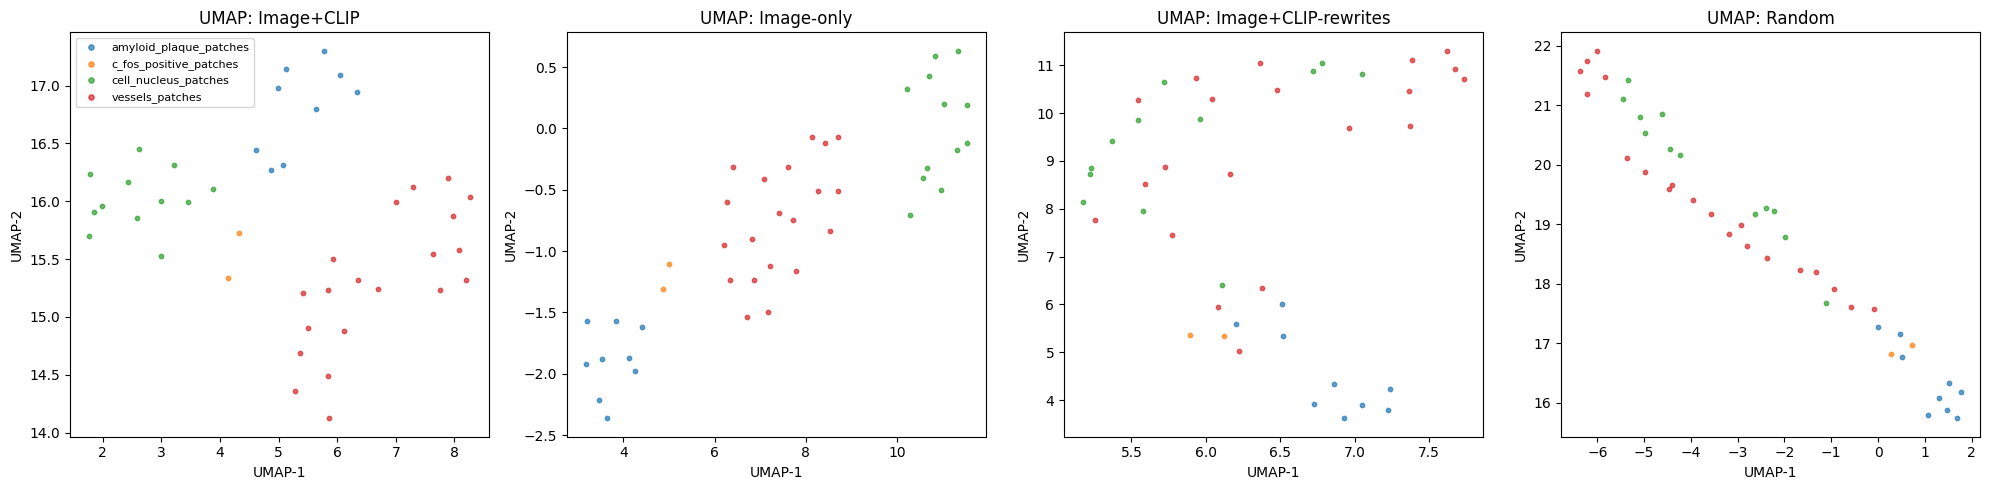


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
1,Image-only,48,256,1.000000,0.352096
0,Image+CLIP,12,512,0.888889,0.192787
3,Random,12,512,0.555556,0.022713
2,Image+CLIP-rewrites,12,128,0.333333,-0.085820


In [26]:
if __name__ == '__main__':
    embeddings_dict, labels, class_names, final_results = main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=10,
        fraction=0.5
    )
    

Loading data...
amyloid_plaque_patches: kept 9/9 images (50.0%)
c_fos_positive_patches: kept 2/2 images (50.0%)
cell_nucleus_patches: kept 12/12 images (50.0%)
vessels_patches: kept 20/20 images (50.0%)

Loaded 43 total patches across 4 classes (50.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---

[Image+CLIP] Train/Val class distribution:
  amyloid_plaque_patches | Train:   7 | Val:   2 | Total:   9
  c_fos_positive_patches | Train:   1 | Val:   1 | Total:   2
  cell_nucleus_patches | Train:  10 | Val:   2 | Total:  12
  vessels_patches      | Train:  16 | Val:   4 | Total:  20
------------------------------------------------------------
Image+CLIP | Epoch 01/5 | Train loss: 1.3940 | Val loss: 1.3154 | Train acc: 0.147 | Val acc: 0.444
Image+CLIP | Epoch 02/5 | Train loss: 1.1631 | Val loss: 1.1900 | Train acc: 0.559 | Val acc: 0.556
Image+CLIP | Epoch 03/5 | Train loss: 0.9793 | Val loss: 1.0937 | Train acc: 0.735 | Val acc: 0.667
Image+CLIP | Epoch 04/5 | Train loss: 0.8504 | Val loss: 1.0209 | Train acc: 0.794 | Val acc: 0.667
Image+CLIP | Epoch 05/5 | Train loss: 0.7408 | Val loss: 0.9708 | Train acc: 0.912 | Val acc: 0.667

--- Linear Probing: Image-only ---

[Image-only] Train/Val class distribution:
  amyloid_plaque_patches | Train:  

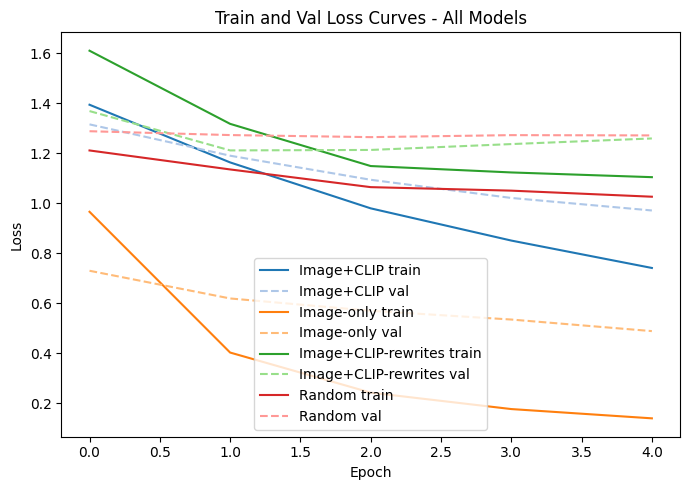

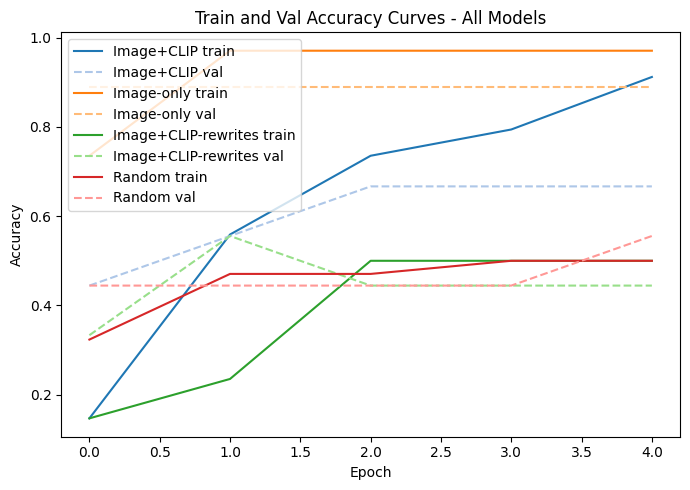

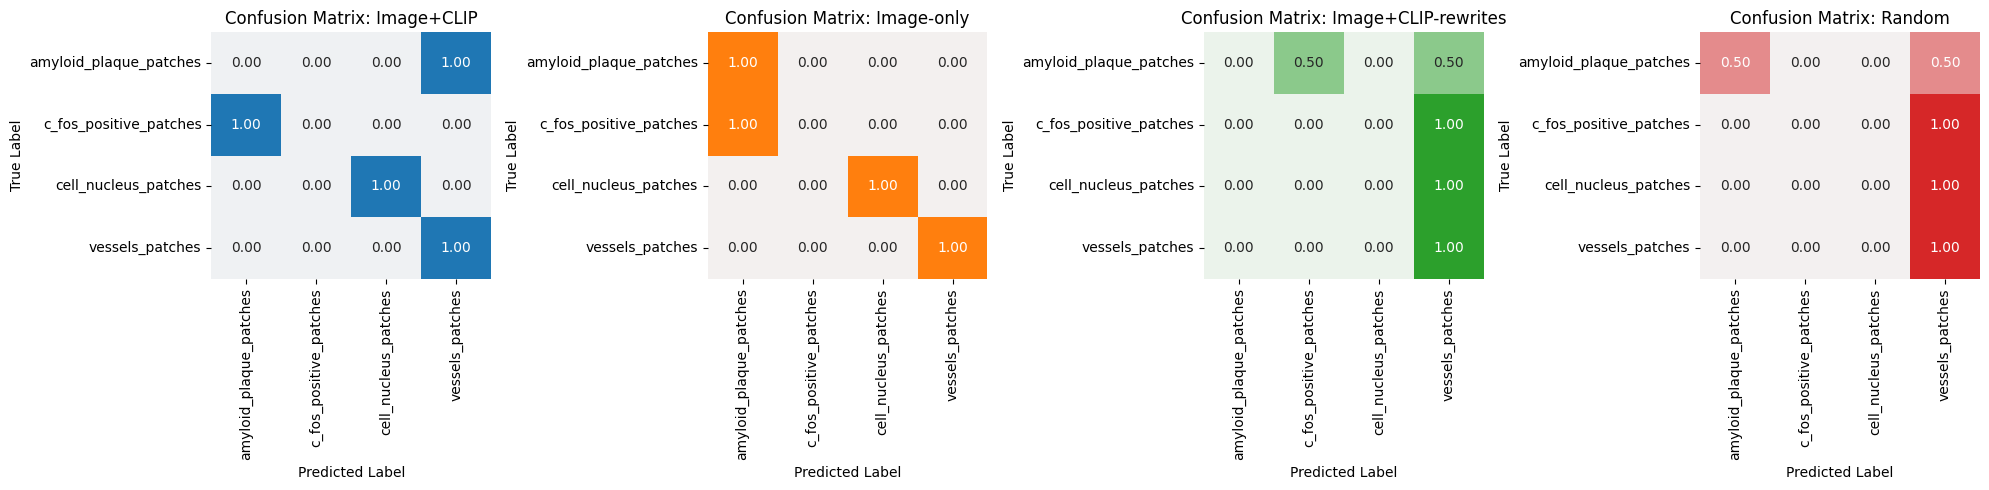

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


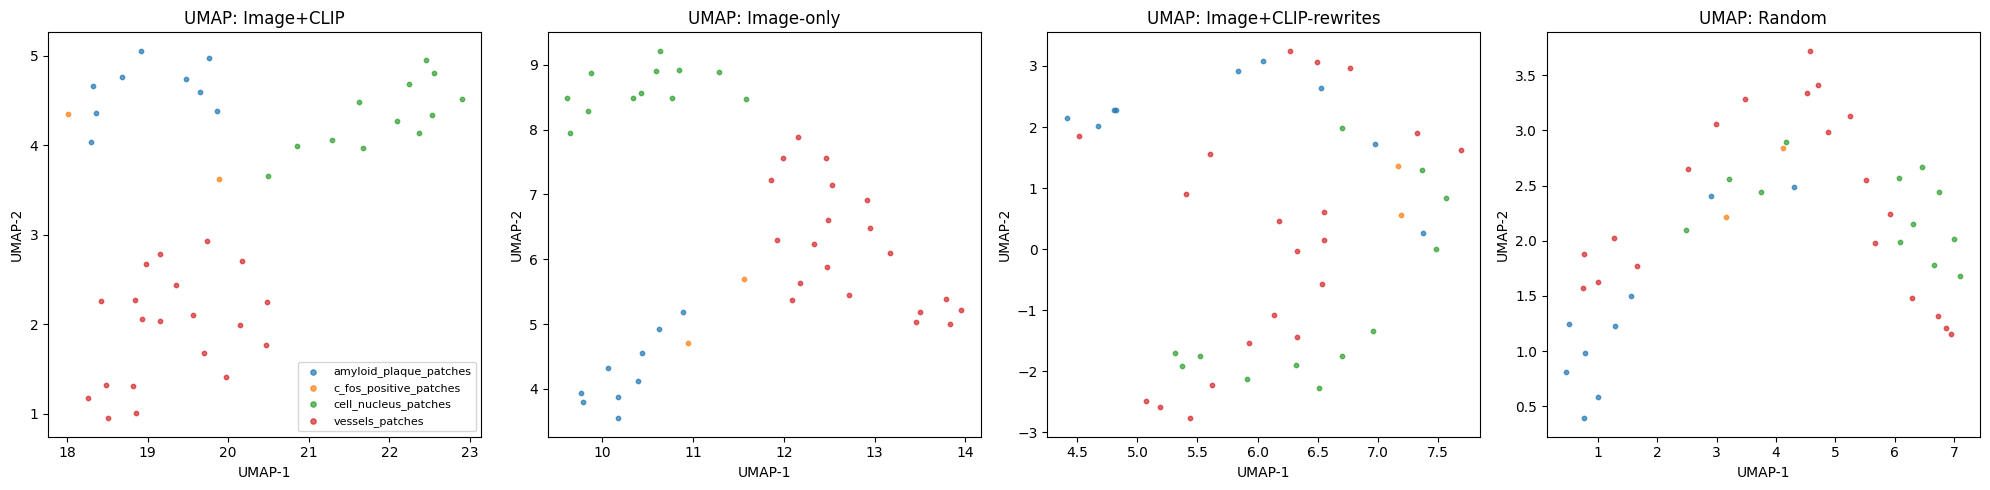


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
1,Image-only,48,256,0.888889,0.317688
0,Image+CLIP,12,512,0.666667,0.236444
3,Random,12,512,0.555556,-0.167815
2,Image+CLIP-rewrites,12,128,0.444444,-0.388365


In [19]:
if __name__ == '__main__':
    main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=5,
        fraction=0.5
    )
    

Loading data...
amyloid_plaque_patches: kept 9/9 images (50.0%)
c_fos_positive_patches: kept 2/2 images (50.0%)
cell_nucleus_patches: kept 12/12 images (50.0%)
vessels_patches: kept 20/20 images (50.0%)

Loaded 43 total patches across 4 classes (50.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---

[Image+CLIP] Train/Val class distribution:
  amyloid_plaque_patches | Train:   7 | Val:   2 | Total:   9
  c_fos_positive_patches | Train:   1 | Val:   1 | Total:   2
  cell_nucleus_patches | Train:  10 | Val:   2 | Total:  12
  vessels_patches      | Train:  16 | Val:   4 | Total:  20
------------------------------------------------------------
Image+CLIP | Epoch 01/1 | Train loss: 1.3846 | Val loss: 1.3308 | Train acc: 0.235 | Val acc: 0.333

--- Linear Probing: Image-only ---

[Image-only] Train/Val class distribution:
  amyloid_plaque_patches | Train:   7 | Val:   2 | Total:   9
  c_fos_positive_patches | Train:   1 | Val:   1 | Total:   2
  cell_nucleus_patches | Train:  10 | Val:   2 | Total:  12
  vessels_patches      | Train:  16 | Val:   4 | Total:  20
------------------------------------------------------------
Image-only | Epoch 01/1 | Train loss: 0.9653 | Val loss: 0.8081 | Train acc: 0.706 | Val acc: 0.778

--- Linear Probing: Image+CLI

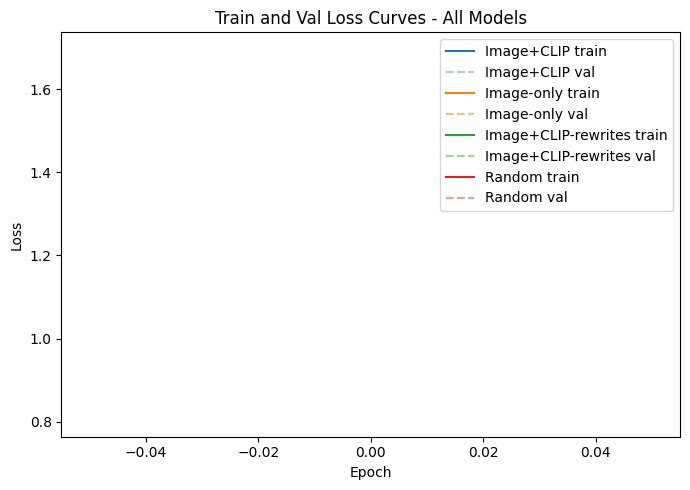

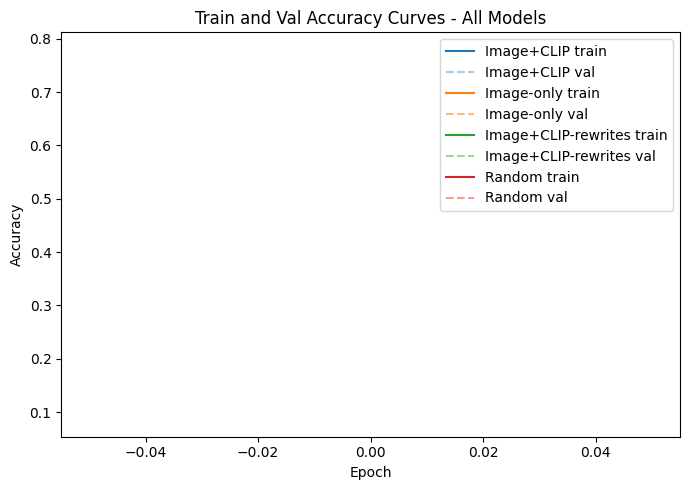

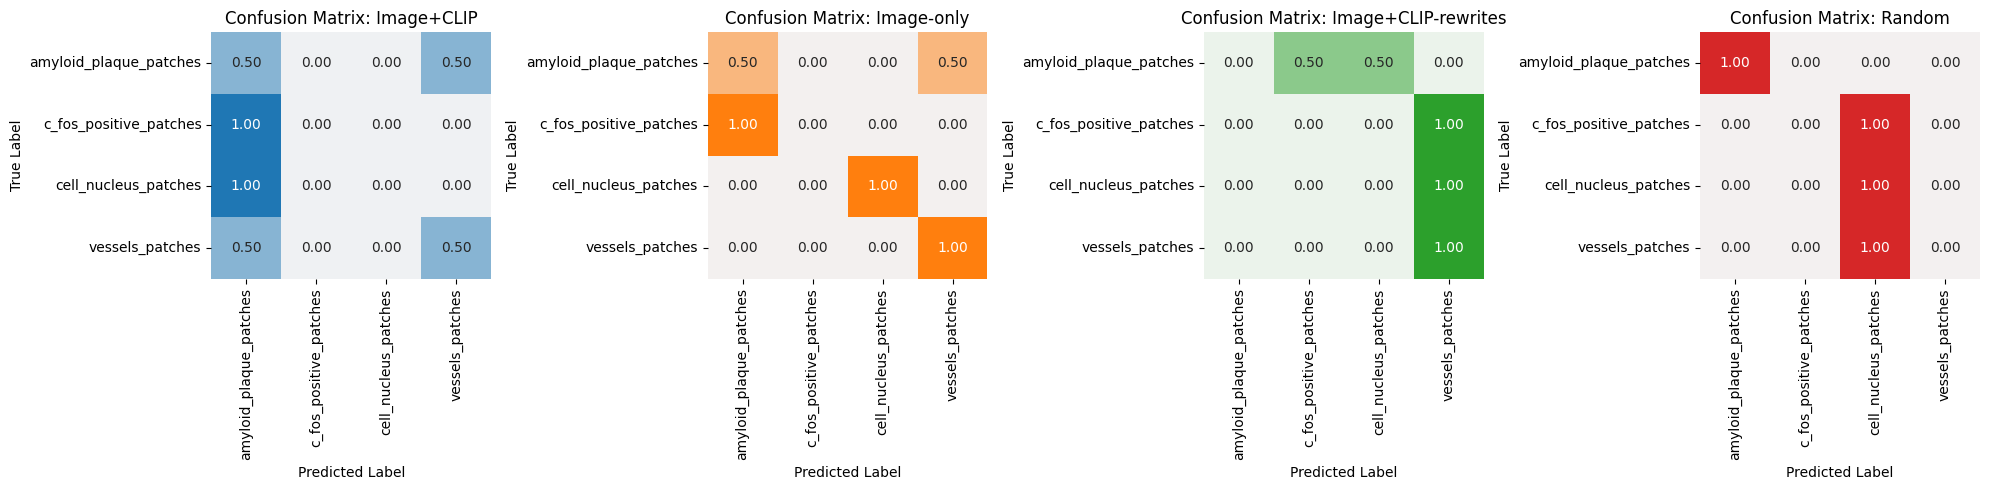

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


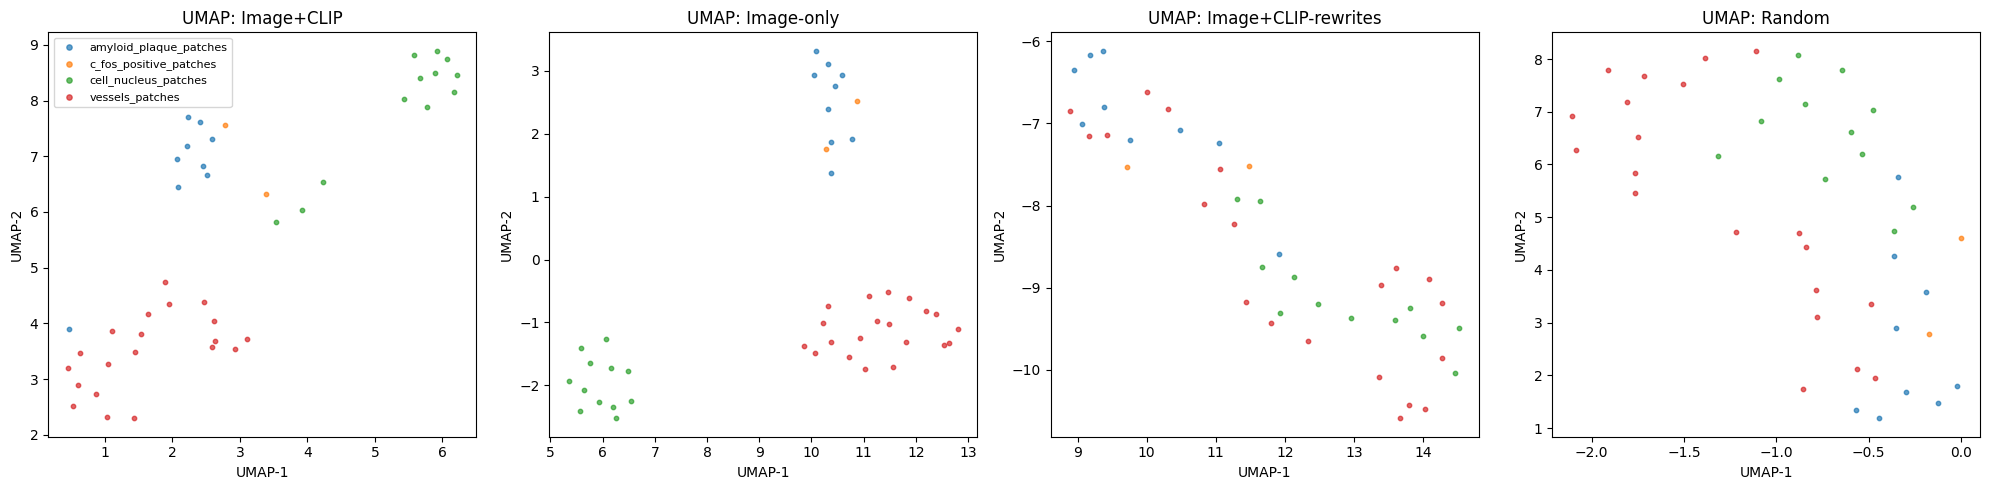


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
1,Image-only,48,256,0.777778,0.339034
2,Image+CLIP-rewrites,12,128,0.444444,-0.238265
3,Random,12,512,0.444444,-0.110502
0,Image+CLIP,12,512,0.333333,0.257702


In [20]:
if __name__ == '__main__':
    main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=1,
        fraction=0.5
    )
    

Loading data...
amyloid_plaque_patches: kept 4/4 images (25.0%)
c_fos_positive_patches: kept 2/2 images (25.0%)
cell_nucleus_patches: kept 6/6 images (25.0%)
vessels_patches: kept 10/10 images (25.0%)

Loaded 22 total patches across 4 classes (25.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---

[Image+CLIP] Train/Val class distribution:
  amyloid_plaque_patches | Train:   3 | Val:   1 | Total:   4
  c_fos_positive_patches | Train:   1 | Val:   1 | Total:   2
  cell_nucleus_patches | Train:   5 | Val:   1 | Total:   6
  vessels_patches      | Train:   8 | Val:   2 | Total:  10
------------------------------------------------------------
Image+CLIP | Epoch 01/10 | Train loss: 1.3104 | Val loss: 1.3850 | Train acc: 0.294 | Val acc: 0.200
Image+CLIP | Epoch 02/10 | Train loss: 1.1768 | Val loss: 1.3459 | Train acc: 0.588 | Val acc: 0.600
Image+CLIP | Epoch 03/10 | Train loss: 1.0879 | Val loss: 1.3219 | Train acc: 0.647 | Val acc: 0.600
Image+CLIP | Epoch 04/10 | Train loss: 1.0098 | Val loss: 1.3050 | Train acc: 0.647 | Val acc: 0.600
Image+CLIP | Epoch 05/10 | Train loss: 0.9476 | Val loss: 1.2806 | Train acc: 0.765 | Val acc: 0.600
Image+CLIP | Epoch 06/10 | Train loss: 0.8855 | Val loss: 1.2538 | Train acc: 0.765 | Val acc: 0.600
Image+CLI

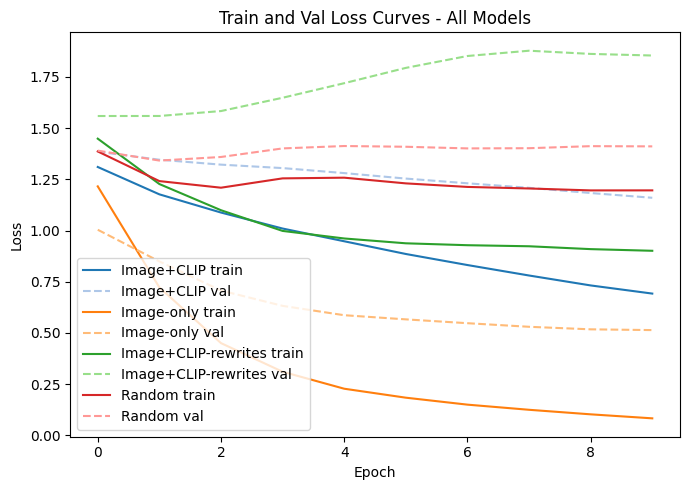

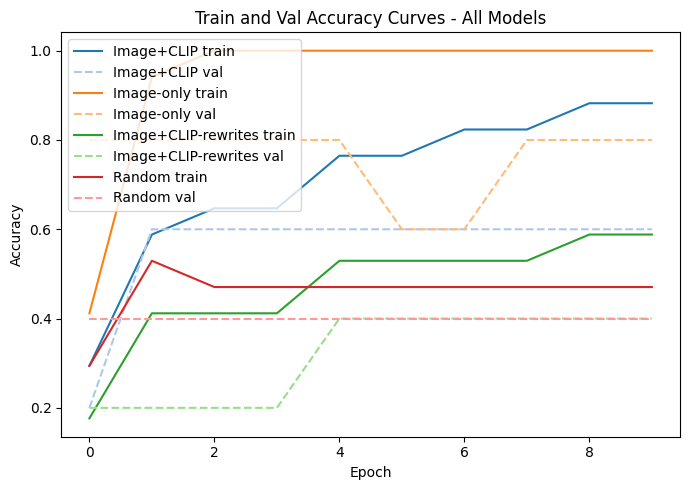

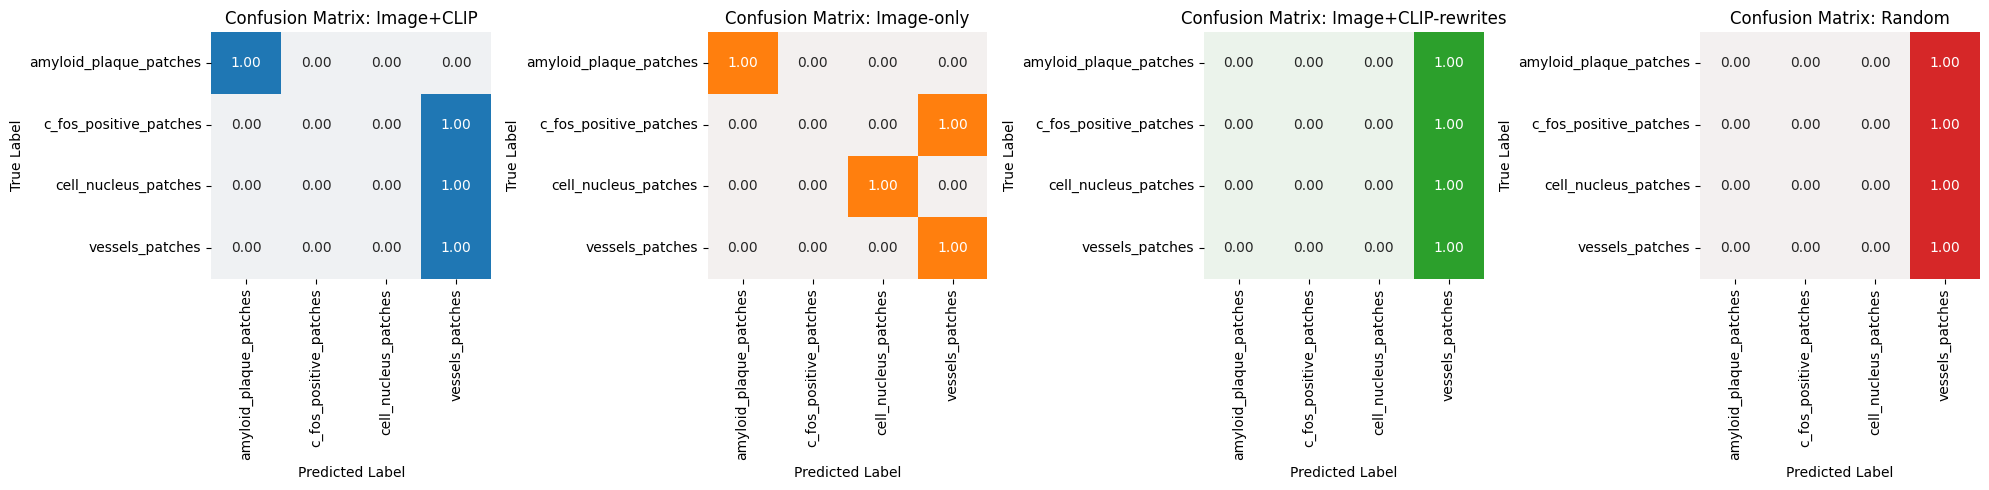

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


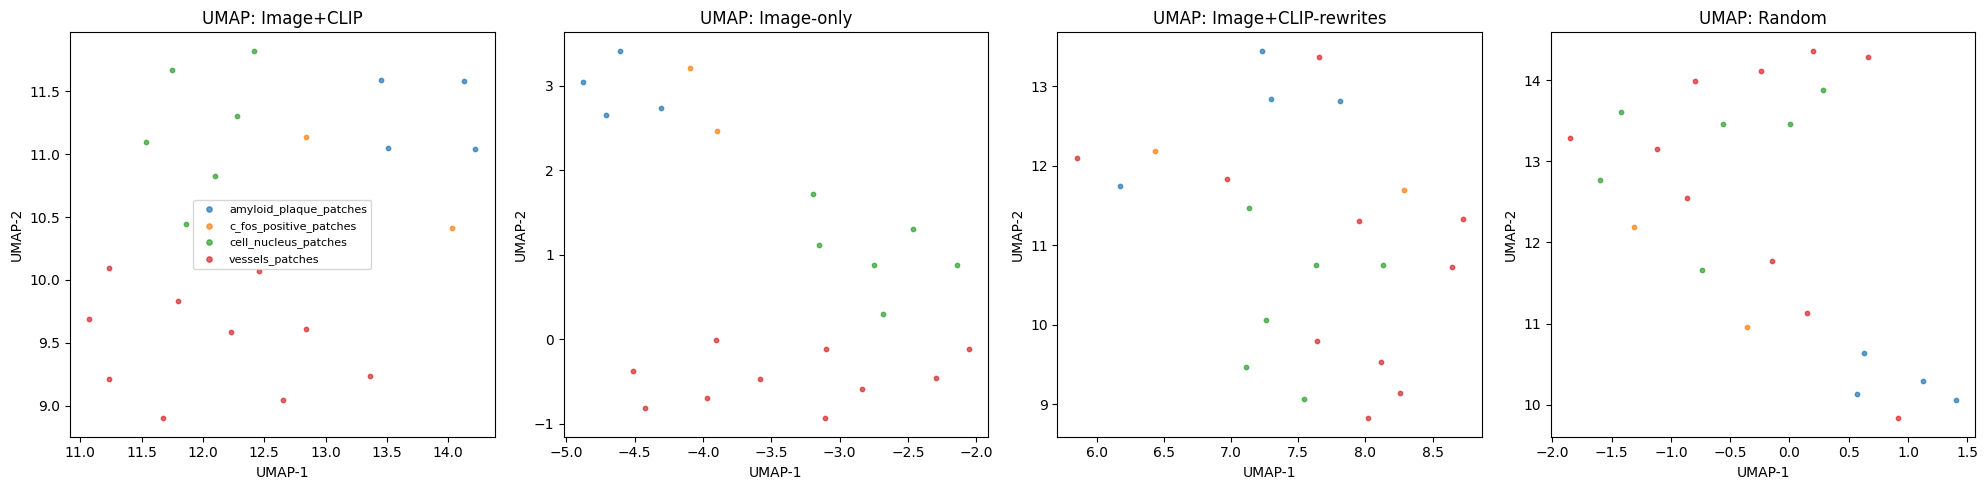


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
1,Image-only,48,256,0.8,0.323849
0,Image+CLIP,12,512,0.6,0.212909
2,Image+CLIP-rewrites,12,128,0.4,-0.258313
3,Random,12,512,0.4,-0.073955


In [ ]:
if __name__ == '__main__':
    main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=10,
        fraction=0.25
    )
    

Loading data...
amyloid_plaque_patches: kept 4/4 images (25.0%)
c_fos_positive_patches: kept 2/2 images (25.0%)
cell_nucleus_patches: kept 6/6 images (25.0%)
vessels_patches: kept 10/10 images (25.0%)

Loaded 22 total patches across 4 classes (25.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---

[Image+CLIP] Train/Val class distribution:
  amyloid_plaque_patches | Train:   3 | Val:   1 | Total:   4
  c_fos_positive_patches | Train:   1 | Val:   1 | Total:   2
  cell_nucleus_patches | Train:   5 | Val:   1 | Total:   6
  vessels_patches      | Train:   8 | Val:   2 | Total:  10
------------------------------------------------------------
Image+CLIP | Epoch 01/5 | Train loss: 1.3055 | Val loss: 1.3269 | Train acc: 0.235 | Val acc: 0.400
Image+CLIP | Epoch 02/5 | Train loss: 1.1561 | Val loss: 1.2670 | Train acc: 0.647 | Val acc: 0.400
Image+CLIP | Epoch 03/5 | Train loss: 1.0530 | Val loss: 1.2211 | Train acc: 0.706 | Val acc: 0.600
Image+CLIP | Epoch 04/5 | Train loss: 0.9764 | Val loss: 1.1813 | Train acc: 0.706 | Val acc: 0.600
Image+CLIP | Epoch 05/5 | Train loss: 0.9152 | Val loss: 1.1464 | Train acc: 0.706 | Val acc: 0.600

--- Linear Probing: Image-only ---

[Image-only] Train/Val class distribution:
  amyloid_plaque_patches | Train:  

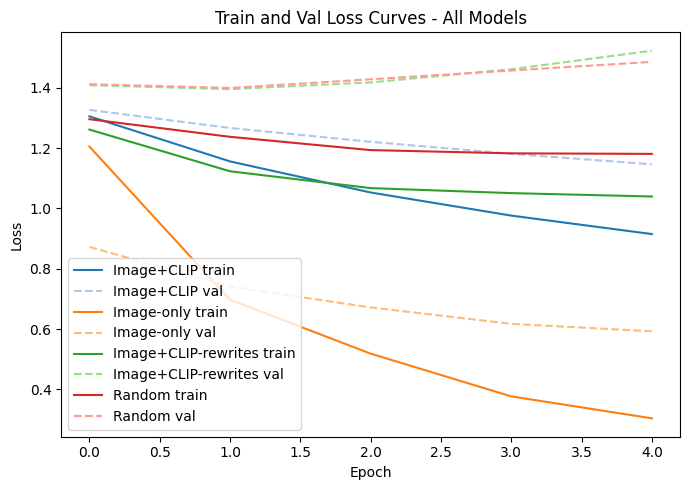

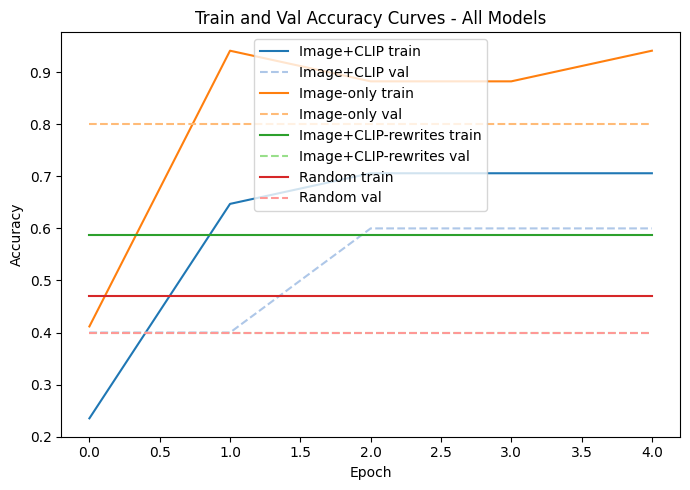

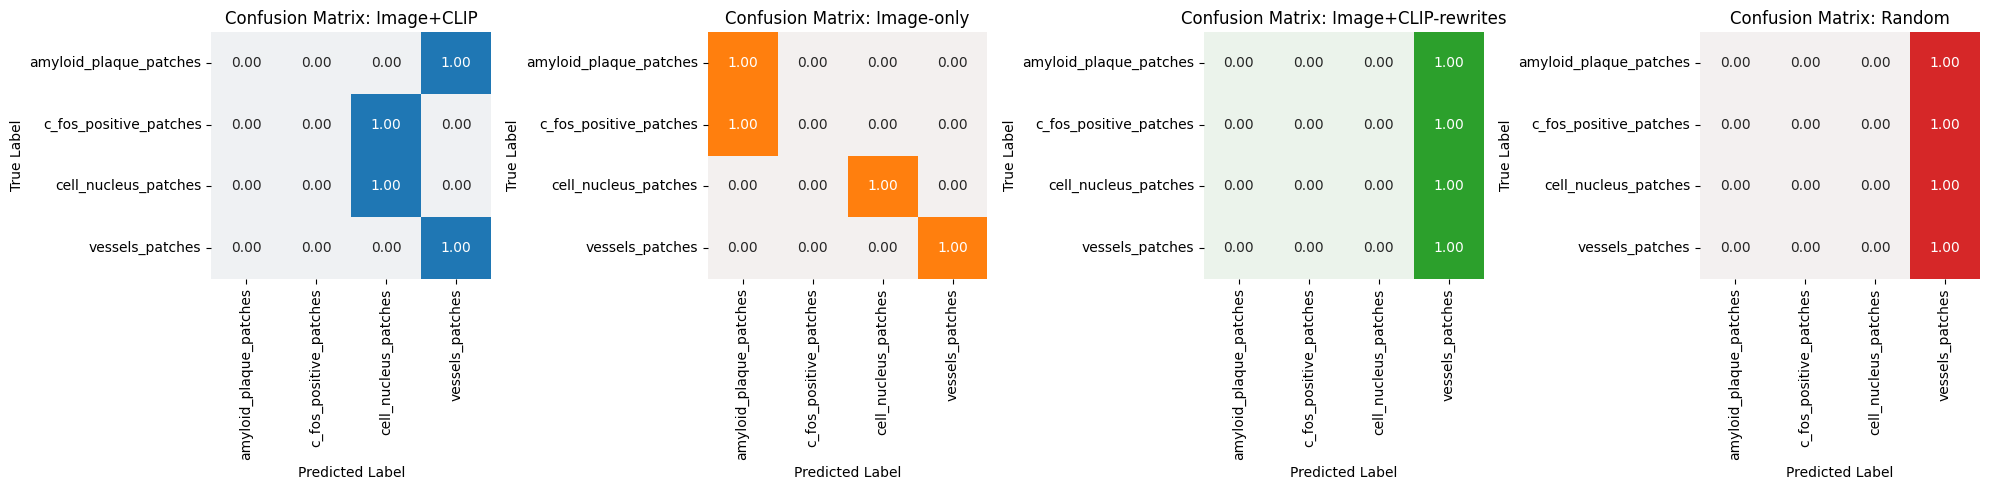

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


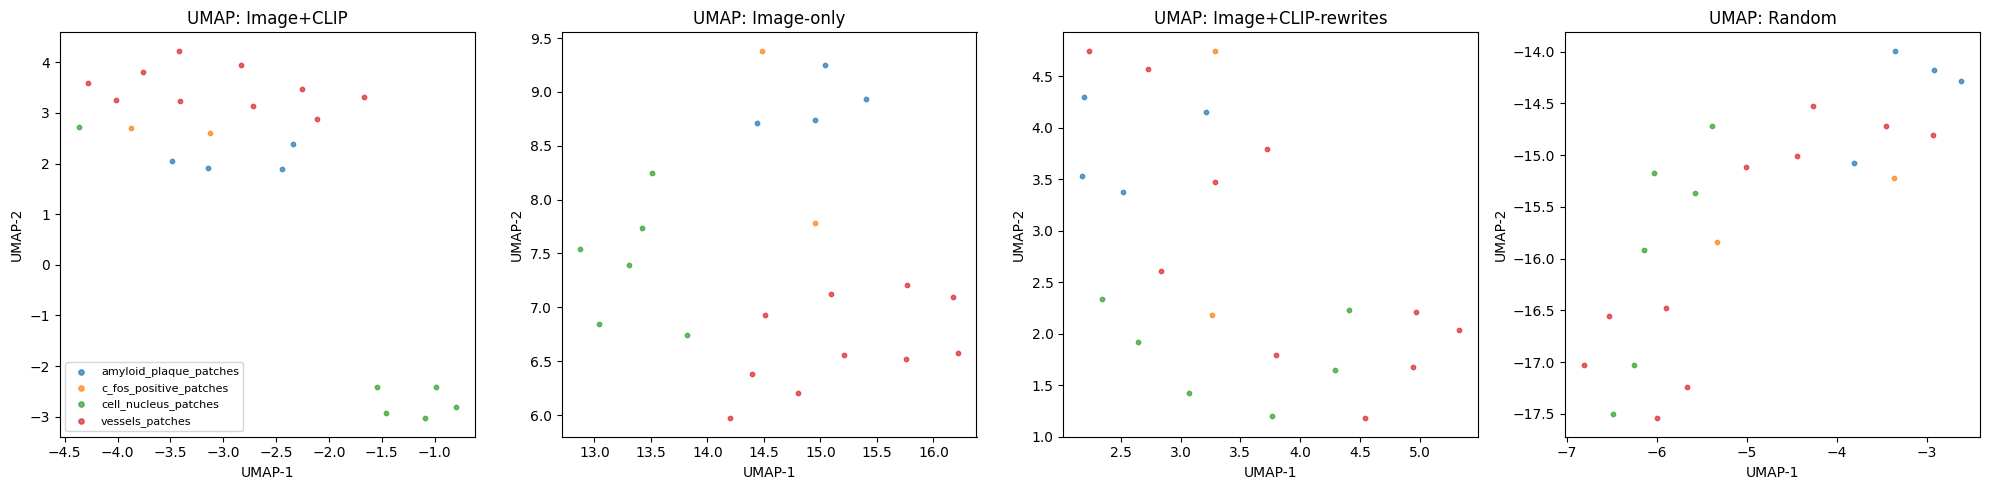


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
1,Image-only,48,256,0.8,0.308645
0,Image+CLIP,12,512,0.6,0.197040
2,Image+CLIP-rewrites,12,128,0.4,-0.132896
3,Random,12,512,0.4,-0.027592


In [ ]:
if __name__ == '__main__':
    main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=5,
        fraction=0.25
    )
    

In [27]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------------
# 1. Define your text prompts for each class
# --------------------------------------------------
text_prompts = {
    "amyloid_plaque_patches": "a 3D light-sheet microscopy image showing an amyloid plaque in brain tissue",
    "c_fos_positive_patches": "a patch showing a c-Fos positive neuron stained in the brain",
    "cell_nucleus_patches": "a 3D microscopy patch showing a stained cell nucleus",
    "vessels_patches": "a patch showing fluorescently labeled blood vessels in the brain"
}

# --------------------------------------------------
# 2. Load the same text encoder used in pretraining
# --------------------------------------------------
# (update the model name to match your CLIP pretraining setup)
text_encoder_name = "bert-base-uncased"  # or your pretrained text model
tokenizer = AutoTokenizer.from_pretrained(text_encoder_name)
text_model = AutoModel.from_pretrained(text_encoder_name).to(device)
text_model.eval()

@torch.no_grad()
def get_text_embeddings(text_prompts):
    texts = list(text_prompts.values())
    enc = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    outputs = text_model(**enc)
    # mean pooling of token embeddings
    emb = outputs.last_hidden_state.mean(dim=1)
    emb = F.normalize(emb, dim=1)  # normalize for cosine similarity
    return {k: v for k, v in zip(text_prompts.keys(), emb)}

text_embs = get_text_embeddings(text_prompts)
print(f"Loaded {len(text_embs)} text embeddings.")

# --------------------------------------------------
# 3. Compute cosine similarities: image ↔ text
# --------------------------------------------------
def evaluate_clip_alignment(image_embs, labels, text_embs, class_names):
    all_preds, all_true = [], []
    text_stack = torch.stack([text_embs[c] for c in class_names]).to(device)

    for img_emb, true_label in zip(image_embs, labels):
        img_emb = torch.tensor(img_emb, dtype=torch.float32, device=device).unsqueeze(0)
        img_emb = F.normalize(img_emb, dim=1)
        sims = torch.mm(img_emb, text_stack.T).squeeze(0)  # cosine similarity
        pred_idx = torch.argmax(sims).item()
        all_preds.append(pred_idx)
        all_true.append(class_names.index(true_label))

    return np.array(all_true), np.array(all_preds)

# --------------------------------------------------
# 4. Run evaluation for your Image+CLIP model only
# --------------------------------------------------
clip_embs = embeddings_dict["Image+CLIP"]
true_labels, pred_labels = evaluate_clip_alignment(clip_embs, labels, text_embs, list(text_prompts.keys()))

# --------------------------------------------------
# 5. Metrics & Confusion Matrix
# --------------------------------------------------
print("\n=== Text-Guided CLIP Classification Report ===")
print(classification_report(true_labels, pred_labels, target_names=list(text_prompts.keys()), digits=3))

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=list(text_prompts.keys()), yticklabels=list(text_prompts.keys()))
plt.title("Image+Text CLIP Alignment — Confusion Matrix")
plt.xlabel("Predicted (Text)")
plt.ylabel("True (Image)")
plt.tight_layout()
plt.show()


Loaded 4 text embeddings.


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x192 and 768x4)

In [30]:
ckpt_clip = "/ministorage/adina/pretrain_sweep/checkpoints/dea46vee/all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt"
ckpt = torch.load(ckpt_clip, map_location="cpu", weights_only=False)
state_dict = ckpt.get("state_dict", ckpt)

# Print only relevant CLIP text keys
for k in state_dict.keys():
    if any(x in k for x in ["text_encoder", "text_proj", "image_proj"]):
        print(k)


text_encoder.embeddings.word_embeddings.weight
text_encoder.embeddings.position_embeddings.weight
text_encoder.embeddings.token_type_embeddings.weight
text_encoder.embeddings.LayerNorm.weight
text_encoder.embeddings.LayerNorm.bias
text_encoder.encoder.layer.0.attention.self.query.weight
text_encoder.encoder.layer.0.attention.self.query.bias
text_encoder.encoder.layer.0.attention.self.key.weight
text_encoder.encoder.layer.0.attention.self.key.bias
text_encoder.encoder.layer.0.attention.self.value.weight
text_encoder.encoder.layer.0.attention.self.value.bias
text_encoder.encoder.layer.0.attention.output.dense.weight
text_encoder.encoder.layer.0.attention.output.dense.bias
text_encoder.encoder.layer.0.attention.output.LayerNorm.weight
text_encoder.encoder.layer.0.attention.output.LayerNorm.bias
text_encoder.encoder.layer.0.intermediate.dense.weight
text_encoder.encoder.layer.0.intermediate.dense.bias
text_encoder.encoder.layer.0.output.dense.weight
text_encoder.encoder.layer.0.output.dens

In [36]:
# --- Create projection head dynamically (robust) ---
if len(proj_sd) == 0:
    print("⚠️ No text_proj weights found — using random initialization.")
    text_proj = torch.nn.Linear(text_model.config.hidden_size, embed_dim, bias=False)
else:
    proj_keys = list(proj_sd.keys())
    layer_ids = sorted(set(k.split('.')[0] for k in proj_keys if k[0].isdigit()))
    layers = []
    print(f"Detected projection structure with layers: {layer_ids}")

    for lid in layer_ids:
        w_key = f"{lid}.weight"
        b_key = f"{lid}.bias"

        if w_key not in proj_sd:
            print(f"Skipping layer {lid}: no weight found")
            continue

        weight = proj_sd[w_key]
        if weight.ndim != 2:
            print(f"Skipping layer {lid}: non-linear layer (shape={weight.shape})")
            continue

        in_features = weight.shape[1]
        out_features = weight.shape[0]
        layer = torch.nn.Linear(in_features, out_features)
        layer.weight = torch.nn.Parameter(weight)
        if b_key in proj_sd:
            layer.bias = torch.nn.Parameter(proj_sd[b_key])
        layers.append(layer)

        # Add GELU between linear layers except the last
        if lid != layer_ids[-1]:
            layers.append(torch.nn.GELU())

    if len(layers) == 0:
        print("⚠️ Projection weights not compatible — falling back to single linear layer.")
        text_proj = torch.nn.Linear(text_model.config.hidden_size, embed_dim, bias=False)
    else:
        text_proj = torch.nn.Sequential(*layers)

text_proj = text_proj.to(device).eval()
print(text_proj)


Detected projection structure with layers: ['0', '2', '3']
Skipping layer 3: non-linear layer (shape=torch.Size([512]))
Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): GELU(approximate='none')
)


In [38]:
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def evaluate_clip_alignment(image_embs, labels, text_embs, class_names, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Evaluate how well image embeddings align with text embeddings via cosine similarity.
    
    Args:
        image_embs (np.ndarray): Array of shape [N, D] with image embeddings.
        labels (list or np.ndarray): True class labels corresponding to image_embs.
        text_embs (dict): Mapping from class name -> torch tensor (text embedding, shape [D]).
        class_names (list): List of class names in consistent order.
        device (str): Device for computation.

    Returns:
        (np.ndarray, np.ndarray): True and predicted label indices.
    """

    # Stack all text embeddings
    text_stack = torch.stack([text_embs[c] for c in class_names]).to(device)

    all_true, all_pred = [], []

    for img_emb, true_label in zip(image_embs, labels):
        img_emb = torch.tensor(img_emb, dtype=torch.float32, device=device).unsqueeze(0)
        img_emb = F.normalize(img_emb, dim=1)

        # cosine similarity with text embeddings
        sims = torch.mm(img_emb, text_stack.T).squeeze(0)  # [n_text_classes]
        pred_idx = torch.argmax(sims).item()

        all_true.append(class_names.index(true_label))
        all_pred.append(pred_idx)

    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    # === Classification metrics ===
    print("\n=== Text-Guided CLIP Classification Report ===")
    print(classification_report(all_true, all_pred, target_names=class_names, digits=3))

    # === Confusion matrix ===
    cm = confusion_matrix(all_true, all_pred, normalize="true")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                fmt=".2f", cbar=False)
    plt.title("Image + Text CLIP Alignment — Confusion Matrix")
    plt.xlabel("Predicted (Text)")
    plt.ylabel("True (Image)")
    plt.tight_layout()
    plt.show()

    return all_true, all_pred


In [41]:
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F

# Example: text_prompts mapping each class to a descriptive sentence
text_prompts = {
    "amyloid_plaque_patches": "a light-sheet microscopy image showing amyloid plaques in the brain",
    "c_fos_positive_patches": "a brain image showing c-Fos positive neurons",
    "cell_nucleus_patches": "a volumetric brain microscopy image showing cell nuclei",
    "vessels_patches": "a 3D microscopy image of blood vessels in the mouse brain"
}

# Initialize tokenizer (make sure it matches the text_model)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

from transformers import AutoTokenizer
import torch
import torch.nn.functional as F

@torch.no_grad()
def get_text_embeddings_true(prompts_dict, text_model, text_proj, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Encodes class text prompts using the CLIP text encoder + projection.
    Returns a dict mapping class_name → embedding (D-dimensional torch tensor).
    """
    text_embs = {}
    text_model = text_model.to(device).eval()
    text_proj = text_proj.to(device).eval()

    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    for cls, text in prompts_dict.items():
        # Tokenize and move to same device as model
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=64
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}  # <-- FIX HERE

        outputs = text_model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        proj_emb = text_proj(cls_emb)
        proj_emb = F.normalize(proj_emb, dim=1)
        text_embs[cls] = proj_emb.squeeze(0).cpu()  # store as [D]

    print(f"Created {len(text_embs)} text embeddings (dim={list(text_embs.values())[0].shape[0]})")
    return text_embs



In [43]:
text_embs_true = get_text_embeddings_true(text_prompts, text_model, text_proj)


Created 4 text embeddings (dim=512)


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [45]:
true_labels, pred_labels = evaluate_clip_alignment(
    image_embs=embeddings_dict["Image+CLIP"],
    labels=labels,
    text_embs=text_embs_true,
    class_names=list(text_embs_true.keys())
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x192 and 512x4)

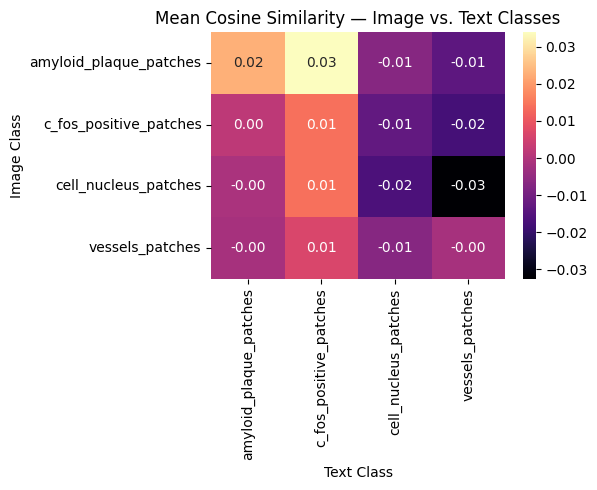

In [57]:
import pandas as pd

# Compute per-class mean image embeddings
mean_img_embs = []
for cls in text_prompts.keys():
    cls_idx = [i for i, lab in enumerate(labels) if lab == cls]
    cls_emb = torch.tensor(img_embs_proj[cls_idx], dtype=torch.float32)
    mean_img_embs.append(F.normalize(cls_emb.mean(dim=0), dim=0))

mean_img_embs = torch.stack(mean_img_embs).to(device)
text_stack = torch.stack([text_embs_true[c] for c in text_prompts.keys()]).to(device)

# Compute cosine similarity matrix
sim_matrix = torch.mm(mean_img_embs, text_stack.T).cpu().numpy()

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="magma",
            xticklabels=list(text_prompts.keys()),
            yticklabels=list(text_prompts.keys()))
plt.title("Mean Cosine Similarity — Image vs. Text Classes")
plt.xlabel("Text Class")
plt.ylabel("Image Class")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Text–Text Cosine Similarity')

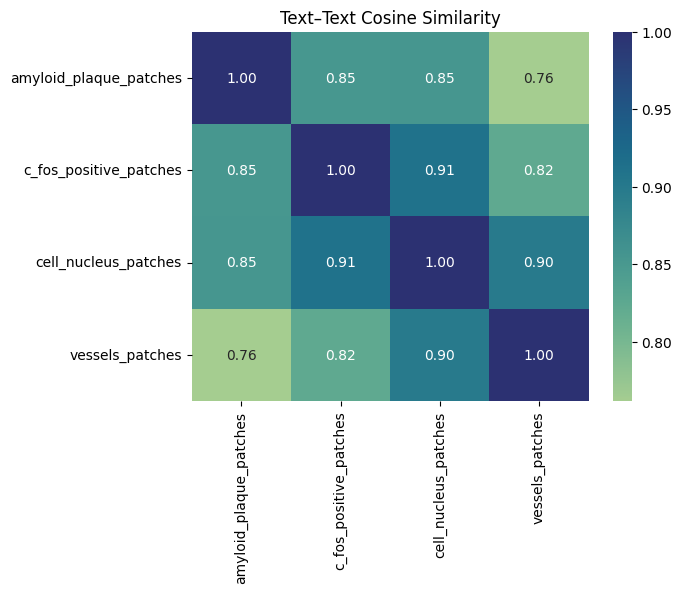

In [58]:
text_stack = torch.stack([v for v in text_embs_true.values()])
sim_text = F.normalize(text_stack, dim=1) @ F.normalize(text_stack, dim=1).T
sns.heatmap(sim_text.cpu(), annot=True, fmt=".2f", cmap="crest",
            xticklabels=text_prompts.keys(), yticklabels=text_prompts.keys())
plt.title("Text–Text Cosine Similarity")


In [59]:
print("Image embedding variance:", img_embs_proj.std(axis=0).mean())


Image embedding variance: 0.018481191


In [60]:
text_model.eval()
base_embs = []
for t in text_prompts.values():
    inputs = tokenizer(t, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = text_model(**inputs)
    base_embs.append(outputs.last_hidden_state[:,0,:].cpu())
base_embs = torch.cat(base_embs)
print("Mean pairwise cosine:", F.cosine_similarity(base_embs.unsqueeze(1), base_embs.unsqueeze(0), dim=-1).mean())


Mean pairwise cosine: tensor(0.8883, grad_fn=<MeanBackward0>)


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [61]:
proj_tensor = torch.stack(list(text_embs_true.values()))
print("Std per dim:", proj_tensor.std(dim=0).mean().item())


Std per dim: 0.015209791250526905


In [62]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

# --- 0) You provide these ---
# image_encoder: Callable[x] -> (B, D) normalized or not
# text_encoder:  Callable[str] -> (D,) or (N, D)
# images: list/iterable of tensors already preprocessed for your backbone
# labels: LongTensor of shape [N] with class ids 0..C-1
# prompts: dict {class_id: [list of prompt strings]}  # use your varied captions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1) Build class text prototypes (prompt ensembling) ---
def encode_texts(batch_strs):
    with torch.no_grad():
        te = text_encoder(batch_strs)          # (B, D)
    return F.normalize(te, dim=-1)

all_class_texts = []
class_offsets = []
for cid in sorted(prompts.keys()):
    Tcid = encode_texts(prompts[cid])          # (#prompts_cid, D)
    proto = F.normalize(Tcid.mean(0, keepdim=True), dim=-1)  # (1, D)
    class_offsets.append(len(all_class_texts))
    all_class_texts.append(proto)
text_protos = torch.cat(all_class_texts, dim=0).to(device)   # (C, D)
C = text_protos.size(0)

# --- 2) Encode images once ---
img_embs = []
with torch.no_grad():
    for x in images:
        z = image_encoder(x.to(device).unsqueeze(0))         # (1, D)
        img_embs.append(z)
img_embs = torch.cat(img_embs, dim=0)                        # (N, D)
img_embs = F.normalize(img_embs, dim=-1)
labels = labels.to(device)
N, D = img_embs.shape

# Optional: learn a single temperature on a held-out set
logit_scale = torch.tensor(1/0.07, device=device)  # CLIP default ~14.285

# --- 3) Zero-shot scores and accuracy ---
logits = logit_scale * (img_embs @ text_protos.T)   # (N, C)
top1 = (logits.argmax(dim=1) == labels).float().mean().item()
top5 = (logits.topk(k=min(5, C), dim=1).indices == labels[:, None]).any(1).float().mean().item()

# --- 4) Retrieval (Image->Text prototypes) ---
# R@K: percentage of images whose true class is within top K
def recall_at_k(logits, labels, k):
    hits = (logits.topk(k=k, dim=1).indices == labels[:, None]).any(1).float()
    return hits.mean().item()

r1 = recall_at_k(logits, labels, 1)
r5 = recall_at_k(logits, labels, min(5, C))
r10 = recall_at_k(logits, labels, min(10, C))

# --- 5) Alignment margin & AUC (pos vs neg) ---
true_scores = logits.gather(1, labels[:, None]).squeeze(1)   # (N,)
max_other = logits.masked_fill(
    F.one_hot(labels, num_classes=C).bool(), float('-inf')
).max(dim=1).values
margin = (true_scores - max_other).mean().item()

# Build labels for AUC: 1 for true pair, 0 for others (subsample negatives for speed)
with torch.no_grad():
    # For efficiency, compare to prototypes only
    y_score = logits.flatten().detach().cpu()                 # (N*C,)
    y_true = F.one_hot(labels, num_classes=C).flatten().cpu() # (N*C,)
    auc = roc_auc_score(y_true.numpy(), y_score.numpy())

print(f"Zero-shot top1: {top1:.3f} | top5: {top5:.3f}")
print(f"Recall@1/5/10: {r1:.3f}/{r5:.3f}/{r10:.3f}")
print(f"Alignment margin: {margin:.3f}")
print(f"Pos-vs-Neg AUC: {auc:.3f}")


NameError: name 'prompts' is not defined